# Double Moon Experiment: MLP 100

In [1]:
import sys
sys.path.insert(1, '../_tools/')
import torch as th
import torch.nn as nn
import numpy as np
from utils.tensordata import TDataset, TDataloader
from utils.model_selection import GridSearchCV, RandomSearchCV, Fixed, LogUniform
from twomoon import TwoMoon
from mlp import MLP_BinaryClassification
import matplotlib.pyplot as plt

exp_name = 'MLP 100'

seed = 42
th.manual_seed(seed)
np.random.seed(seed)
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

### Data

In [2]:
Ndata = 1000
twomoon = TwoMoon(noise=0)
x, y = twomoon.sample(Ndata)
x, y = th.from_numpy(x).float().to(device), th.from_numpy(y).long().to(device)
DT = TDataset(x, y)
DS, TS = DT.random_split(0.8)
TR, VL = DS.random_split(0.8)

# Dataloaders
batch_size = 128
DS_dl = DS.dataloader('shuffle', batch_size)
TR_dl = TR.dataloader('shuffle', batch_size)
VL_dl = VL.dataloader()
TS_dl = TS.dataloader()

### Model

In [3]:
Model = MLP_BinaryClassification

***

### Manual Model Selection

I do *manual* model selection when during the preliminary screening I realize that it's easy to get 100% accuracy on VL

In [4]:
hyp = {
    'A': (2, 100, 100, 100, 1),
    'f_hid': nn.ReLU(),
    'lr_hot': 0.01,
    'lr_cold': 0.01,
    'momentum': 0.96, 
    'weight_decay': 5e-5,
    'Nepochs': 300
}
M = Model(hyp).to(device)
M.fit(TR_dl)

acc(TR) = 100 %
acc(VL) = 100 %


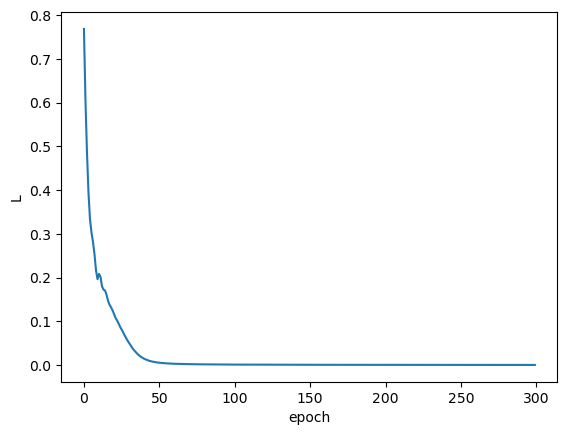

In [5]:
M.plot_curve()
print(f"acc(TR) = {(1-M.TS_loop(TR_dl))*100:.3g} %")
print(f"acc(VL) = {(1-M.TS_loop(VL_dl))*100:.3g} %")

### Final Retraining

In [6]:
print('\n' + '-'*20 + "Final Retraining" + '-'*20)
M.fit(DS_dl)
print(f"acc(TR) = {(1-M.TS_loop(DS_dl))*100:.3g} %")
th.save(M, 'final models/' + exp_name + '.pt')


--------------------Final Retraining--------------------
acc(TR) = 100 %


***

### Analysis

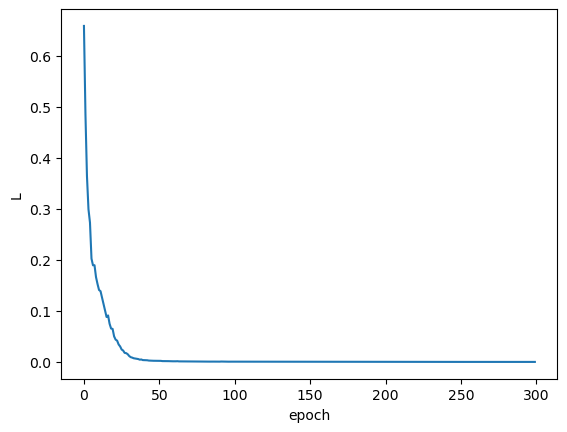

In [7]:
M = th.load('final models/' + exp_name + '.pt').to(device)
M.plot_curve()

#### Double Moon Plots

acc(TS) = 100 %


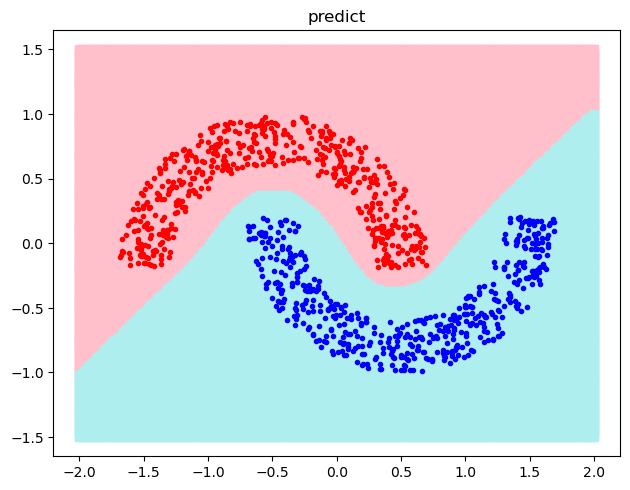

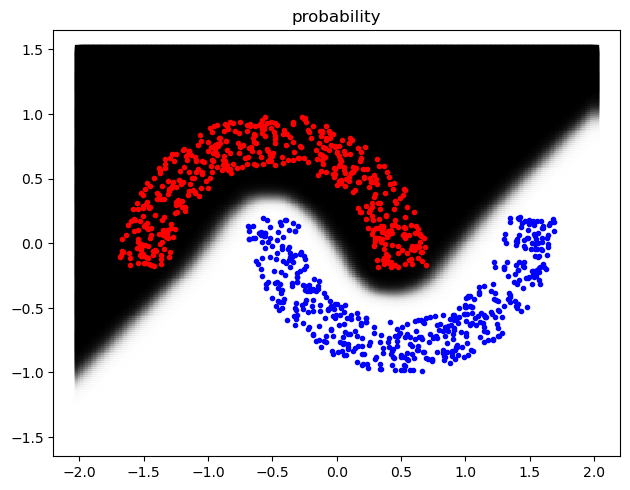

In [8]:
x_gr = twomoon.grid_sample()
x_gr_th = th.from_numpy(x_gr).float().to(device)

print(f"acc(TS) = {(1-M.TS_loop(TS_dl))*100:.3g} %")

y_gr = M.predict(x_gr_th).cpu().numpy()
twomoon.plot(x_gr, y_gr)
plt.title(f"predict")

proba = M.predict_proba(x_gr_th).cpu().numpy()
twomoon.plot_proba(x_gr, proba)
plt.title(f"probability")
pass

#### Different initializations different results?

In [9]:
M = th.load('final models/' + exp_name + '.pt').to(device)

N_trials = 5
TS_acc = []
for i in range(N_trials):
    M.fit(DS_dl)
    TS_acc.append((1-M.TS_loop(TS_dl))*100)   
TS_acc = np.asarray(TS_acc)
TS_mean = np.mean(TS_acc)
TS_std = np.std(TS_acc, ddof=1)

print(f"acc(TS) = {TS_mean:.3g} +- {TS_std:.3g} %")

acc(TS) = 100 +- 0 %
